In [1]:
!hostname
!pwd

c0709a-s30.ufhpc
/home/ekoenig/analysis/studies/jupyter/delphes


In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
fname = '/home/ekoenig/analysis/simulation/MG5_aMC_v2_9_16/cards/ggHHto4b/Events/run_02/tag_1_delphes_events.root'

tree = Tree([fname], treename='Delphes', normalization=None, weights=[], is_signal=True, sample='ggHH4b')

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


In [9]:
varmap = { field.replace('.','_'):field for field in tree.fields if '.' in field }
tree.varmap = varmap

100%|██████████| 1/1 [00:00<00:00, 92.70it/s]


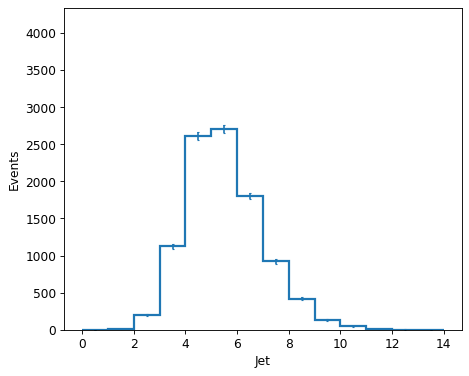

In [10]:
study.quick(
    [tree],
    varlist=['Jet'],
    lumi=None,
)

In [11]:
genparts = ak.zip(dict(
    pt=tree.Particle_PT,
    eta=tree.Particle_Eta,
    phi=tree.Particle_Phi,
    mass=tree.Particle_Mass,
    pid=tree.Particle_PID,
    status=tree.Particle_Status,
), with_name='Momentum4D')

In [12]:
is_b = abs(genparts.pid) == 5
outgoing = genparts.status == 23
bquarks= genparts[is_b & outgoing]

In [13]:
genjets = ak.zip(dict(
    pt=tree.GenJet_PT,
    eta=tree.GenJet_Eta,
    phi=tree.GenJet_Phi,
    mass=tree.GenJet_Mass,
), with_name='Momentum4D')

In [14]:
recojets = ak.zip(dict(
    pt=tree.Jet_PT,
    eta=tree.Jet_Eta,
    phi=tree.Jet_Phi,
    mass=tree.Jet_Mass,
    btag=tree.Jet_BTag,
), with_name='Momentum4D')

In [26]:
def dr_match_objs(obj1_p4, obj2_p4):
    n_obj1 = ak.num(obj1_p4, axis=1)
    n_obj2 = ak.num(obj2_p4, axis=1)

    obj1_obj2_dr = ak.flatten(obj1_p4.deltaR(obj2_p4[:,None]), axis=2)
    obj1_obj2_index = ak.local_index(obj1_obj2_dr)
    mask = ak.ones_like(obj1_obj2_dr, dtype=bool)

    niters = ak.max(ak.min(ak.concatenate([n_obj1[:,None], n_obj2[:,None]], axis=1), axis=1))

    obj1_index = ak.local_index(obj1_p4.pt)
    obj1_matched_dr = -ak.ones_like(obj1_p4.pt)
    obj1_matched_idx = -ak.ones_like(obj1_p4.pt, dtype=int)

    obj2_index = ak.local_index(obj2_p4.pt)
    obj2_matched_dr = -ak.ones_like(obj2_p4.pt)
    obj2_matched_idx = -ak.ones_like(obj2_p4.pt,  dtype=int)

    for _ in range(niters):
        masked_obj1_obj2_dr = ak.where(mask, obj1_obj2_dr, 999)
        mindr, argmin = ak.min(masked_obj1_obj2_dr, axis=1), ak.argmin(masked_obj1_obj2_dr, axis=1)

        matched_obj1_idx = argmin % n_obj1
        matched_obj2_idx = argmin // n_obj1

        matched_obj1_idx = ak.where(mindr == 999, -1, matched_obj1_idx)
        matched_obj2_idx = ak.where(mindr == 999, -1, matched_obj2_idx)
        mindr = ak.where(mindr == 999, -1, mindr)

        obj1_matched_dr = ak.where( (obj1_index == matched_obj1_idx) & (obj1_matched_dr == -1), mindr, obj1_matched_dr )
        obj1_matched_idx = ak.where( (obj1_index == matched_obj1_idx) & (obj1_matched_idx == -1), matched_obj2_idx, obj1_matched_idx )

        obj2_matched_dr = ak.where( (obj2_index == matched_obj2_idx) & (obj2_matched_dr == -1), mindr, obj2_matched_dr )
        obj2_matched_idx = ak.where( (obj2_index == matched_obj2_idx) & (obj2_matched_idx == -1), matched_obj1_idx, obj2_matched_idx )

        mask = mask & ~( ( (obj1_obj2_index % n_obj1) == matched_obj1_idx ) | ( (obj1_obj2_index // n_obj1) == matched_obj2_idx ) )

    return obj1_matched_dr, obj1_matched_idx, obj2_matched_dr, obj2_matched_idx


In [27]:
bquarks['matched_genjet_dr'], bquarks['matched_genjet_idx'], genjets['matched_bquark_dr'], genjets['matched_bquark_idx'] = dr_match_objs(bquarks, genjets)

In [28]:
genjets['matched_recojet_dr'], genjets['matched_recojet_idx'], recojets['matched_genjet_dr'], recojets['matched_genjet_idx'] = dr_match_objs(genjets, recojets)

In [31]:
recojets['matched_bquark_idx'] = genjets.matched_bquark_idx[recojets.matched_genjet_idx]

In [32]:
recojets.matched_bquark_idx

<Array [[0, 2, -1, 1], ... [1, 3, 0, 2]] type='10000 * option[var * int64]'>

100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


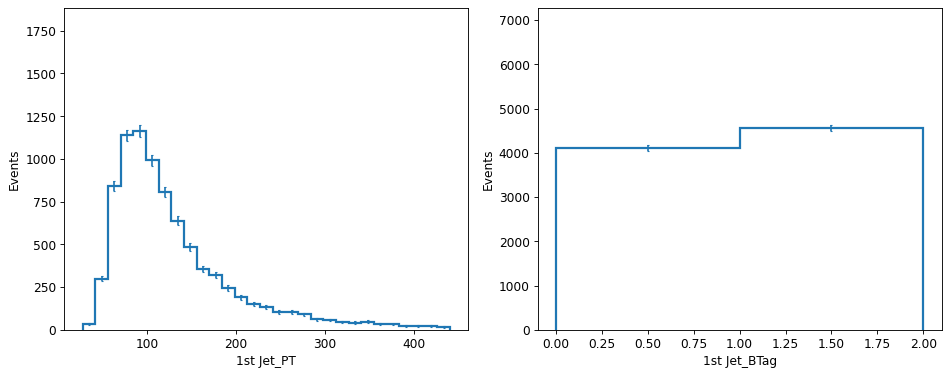

In [30]:
study.quick(
    [tree],
    varlist=['Jet_PT[:,0]','Jet_BTag[:,0]'],
    lumi=None,
)